## Module 5 Project Submission

Please fill out:
* Student name: **Savannah McAmis**
* Student pace: full time
* Scheduled project review date/time: 1/15/20 10:30am EST
* Instructor name: Rafael Carrasco
* Blog post URL: https://medium.com/@savannahmcamis/using-machine-learning-to-identify-under-served-customers-f58978e3b124


The Rent the Runway data set contains customer reviews of rented garments along with details about the customer's body. 

Data set from https://www.kaggle.com/rmisra/clothing-fit-dataset-for-size-recommendation.

Use Machine Learning to match customers with clothing to best fit their bodies and identify gaps in inventory. 

Classify if the rating will be 10 or less.

Identify gaps in inventory

Identify under-served demographics


In [171]:
#Import necessary Libraries

import pandas as pd
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Format data
from datetime import datetime

#Sentiment Scores
from textblob import TextBlob

#Machine Learning
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 42
pd.set_option('display.max_columns', None)

In [3]:
#Load and view the data set
renttherunway = pd.read_json('renttherunway_final_data.json', lines=True)
renttherunway.head()

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
0,28.0,hourglass,34d,romper,fit,"5' 8""",2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs
1,36.0,straight & narrow,34b,gown,fit,"5' 6""",153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs
2,116.0,NaN,NaN,sheath,fit,"5' 4""",1063761,10.0,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN
3,34.0,pear,34c,dress,fit,"5' 5""",126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs
4,27.0,athletic,34b,gown,fit,"5' 9""",616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs


In [4]:
renttherunway.shape

(192544, 15)


## Preprocessing
* Standardize column names - The first thing I notice is that some column names use spaces and some use underscores. I will replace all spaces with underscores.
* Handle null values
* Look for placeholders
* Inspect data types
    * Convert height and weight from string to float
* Identify continuous features
    * age, height, weight
    * size? review_date?
    * review_summary, review_text
        * get sentiment score if time allows
* Identify categorical features
    * body_type, bust_size, category, fit, item_id, rented_for, user_id

### Standardize column names

The first thing I notice is that some column names use spaces and some use underscores. I will replace all spaces with underscores.

In [5]:
renttherunway.columns

Index(['age', 'body type', 'bust size', 'category', 'fit', 'height', 'item_id',
       'rating', 'rented for', 'review_date', 'review_summary', 'review_text',
       'size', 'user_id', 'weight'],
      dtype='object')

In [6]:
#Standardize column names
renttherunway.columns = renttherunway.columns.str.replace(' ', '_')
renttherunway.columns

Index(['age', 'body_type', 'bust_size', 'category', 'fit', 'height', 'item_id',
       'rating', 'rented_for', 'review_date', 'review_summary', 'review_text',
       'size', 'user_id', 'weight'],
      dtype='object')

### Handle null values

Seven of the 15 columns contain some null values, with the most in 'weight' containing almost 16% null values. However, null values account for less than 2.3% of the whole data set. Because of the size of my original data set, I will drop all null values for now. For extention work, I can experiment with other methods of handling null values after modeling.

In [7]:
renttherunway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
age               191584 non-null float64
body_type         177907 non-null object
bust_size         174133 non-null object
category          192544 non-null object
fit               192544 non-null object
height            191867 non-null object
item_id           192544 non-null int64
rating            192462 non-null float64
rented_for        192534 non-null object
review_date       192544 non-null object
review_summary    192544 non-null object
review_text       192544 non-null object
size              192544 non-null int64
user_id           192544 non-null int64
weight            162562 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [8]:
#Explore null values
print("Null values as a percent of the whole data set")
renttherunway.isna().sum().sum()/renttherunway.size

Null values as a percent of the whole data set


0.02242223422525068

In [9]:
print("Null values as percent of total data by feature")
renttherunway.isna().sum()/len(renttherunway)

Null values as percent of total data by feature


age               0.004986
body_type         0.076019
bust_size         0.095620
category          0.000000
fit               0.000000
height            0.003516
item_id           0.000000
rating            0.000426
rented_for        0.000052
review_date       0.000000
review_summary    0.000000
review_text       0.000000
size              0.000000
user_id           0.000000
weight            0.155715
dtype: float64

In [10]:
#Drop all null values
rtr = renttherunway.dropna()
print(f"Original dataset: {renttherunway.shape} \nDataset after nulls dropped: {rtr.shape}")

Original dataset: (192544, 15) 
Dataset after nulls dropped: (146381, 15)


In [11]:
#Check for nulls
rtr.isna().sum().sum()

0

### Look for placeholders

To ensure there are no place holders, I will inspect the summary statistics and value counts for each column. No placeholders stand out. I do notice a few entries that could be combined into larger categories without a loss of information (i.e. combining the cocktail dress with party dresses) and that some columns may be better as ranges (age, size and weight).

In [12]:
#Inspect summary statistics
rtr.describe()

,age,item_id,rating,size,user_id
count,146381.000000,1.463810e+05,146381.000000,146381.000000,146381.000000
mean,34.089800,1.052277e+06,9.081985,11.437919,498991.574528
std,8.113217,8.091076e+05,1.437853,7.826784,289658.524623
min,0.000000,1.233730e+05,2.000000,0.000000,9.000000
25%,29.000000,1.956130e+05,8.000000,4.000000,249294.000000
50%,32.000000,9.618190e+05,10.000000,9.000000,499034.000000
75%,37.000000,1.687082e+06,10.000000,16.000000,750840.000000
max,117.000000,2.966087e+06,10.000000,58.000000,999997.000000


In [14]:
rtr.head()

,age,body_type,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight
0,28.0,hourglass,34d,romper,fit,"5' 8""",2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs
1,36.0,straight & narrow,34b,gown,fit,"5' 6""",153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs
3,34.0,pear,34c,dress,fit,"5' 5""",126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs
4,27.0,athletic,34b,gown,fit,"5' 9""",616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs
5,45.0,athletic,32b,dress,fit,"5' 8""",364092,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs


In [15]:
def remove_outliers(df, col):
    """
    Removes outliers from dataframe column that 
    are more that two standard deviations away 
    from the mean.
    
    Parameters:
    df: datafame
    col: column
    
    Returns:
    dataframe with outliers removed
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound  = q1 - (2 * iqr)
    upper_bound = q3 + (2 * iqr)
    out_df = df.loc[(df[col] > lower_bound) 
                    & (df[col] < upper_bound)]
    return out_df

#### Column: age

In [16]:
rtr.age.describe()

count    146381.000000
mean         34.089800
std           8.113217
min           0.000000
25%          29.000000
50%          32.000000
75%          37.000000
max         117.000000
Name: age, dtype: float64

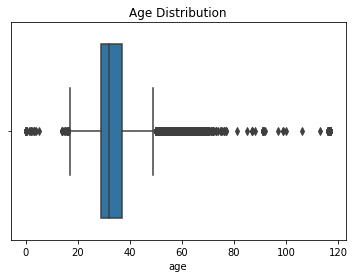

In [17]:
#sns.set(style='whitegrid', rc={'figure.figsize':(12,9)}, font_scale=2)
sns.boxplot(x=rtr.age).set_title('Age Distribution');

In [18]:
len(rtr.age)

146381

In [19]:
rtr = remove_outliers(rtr, 'age')

In [20]:
rtr.age.describe()

count    140783.000000
mean         33.151567
std           6.519426
min          14.000000
25%          29.000000
50%          32.000000
75%          37.000000
max          52.000000
Name: age, dtype: float64

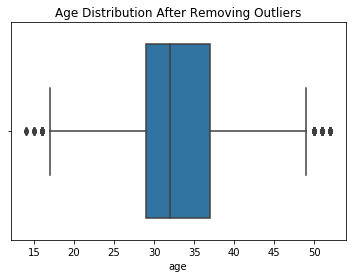

In [21]:
sns.boxplot(x=rtr.age).set_title('Age Distribution After Removing Outliers');

#### Column: body_type

Body type is a categorical variable. When it comes to women's clothing, body type can make a big difference in fit. I will keep the information from this column but create dummy variables for each of the 7 body types. To avoid multicollinearity, I will drop the first dummy column and then merge them into the dataset. 

In [22]:
dummies = pd.get_dummies(rtr['body_type'], drop_first=True)

In [23]:
dummies.columns = ['body_athletic', 'body_full_bust', 'body_hourglass', 
                   'body_pear', 'body_petite', 'body_straight_narrow']
dummies.head()

,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow
0,0,0,1,0,0,0
1,0,0,0,0,0,1
3,0,0,0,1,0,0
4,1,0,0,0,0,0
5,1,0,0,0,0,0


In [24]:
merged = pd.concat([rtr, dummies], axis=1)
merged.head()

,age,body_type,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow
0,28.0,hourglass,34d,romper,fit,"5' 8""",2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0
1,36.0,straight & narrow,34b,gown,fit,"5' 6""",153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1
3,34.0,pear,34c,dress,fit,"5' 5""",126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0
4,27.0,athletic,34b,gown,fit,"5' 9""",616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0
5,45.0,athletic,32b,dress,fit,"5' 8""",364092,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0


In [25]:
rtr = merged.drop(['body_type'], axis=1)
rtr.head()

,age,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow
0,28.0,34d,romper,fit,"5' 8""",2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0
1,36.0,34b,gown,fit,"5' 6""",153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1
3,34.0,34c,dress,fit,"5' 5""",126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0
4,27.0,34b,gown,fit,"5' 9""",616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0
5,45.0,32b,dress,fit,"5' 8""",364092,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0


#### Column: bust_size

Bust size is a complicated variable to deal with. There are so many variables that go into a bra measurement. For simplicity, I will drop this column completely.

In [26]:
rtr.drop(columns='bust_size', inplace=True)
rtr.head()

,age,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow
0,28.0,romper,fit,"5' 8""",2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0
1,36.0,gown,fit,"5' 6""",153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1
3,34.0,dress,fit,"5' 5""",126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0
4,27.0,gown,fit,"5' 9""",616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0
5,45.0,dress,fit,"5' 8""",364092,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0


#### Column: category

There are 68 different category strings. For model simplicity, I will drop this column.

In [27]:
rtr.category.nunique()

68

In [28]:
rtr.drop(columns='category', inplace=True)
rtr.head()

,age,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow
0,28.0,fit,"5' 8""",2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0
1,36.0,fit,"5' 6""",153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1
3,34.0,fit,"5' 5""",126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0
4,27.0,fit,"5' 9""",616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0
5,45.0,fit,"5' 8""",364092,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0


#### Column: fit

These values are stored as strings with 3 options: fit, small, and large. Over 70% of the reviews are labeled 'fit'. I will convert this column to a binary (1 = fit, 0 = not fit).

In [29]:
rtr.fit.value_counts()

fit      103598
small     18745
large     18440
Name: fit, dtype: int64

In [30]:
len(rtr.loc[(rtr.fit == 'fit')])/len(rtr)

0.7358700979521675

In [31]:
rtr.fit = rtr.fit.map({'fit':1, 'small':0, 'large':0})

In [32]:
rtr.fit.value_counts()

1    103598
0     37185
Name: fit, dtype: int64

#### Column: height

Height needs to be stored as integers instead of strings. I will convert the measurement to inches. I will also remove any outliers.

In [33]:
def parse_height(height):
    # Convert string format (ft' in") to float (inches)
    ht = height.split("' ")
    ft = float(ht[0])
    inch = float(ht[1].replace("\"",""))
    return 12*ft + inch

In [34]:
rtr['height'] = rtr['height'].apply(lambda x: parse_height(x))

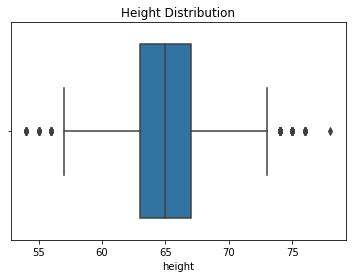

In [35]:
sns.boxplot(x=rtr.height).set_title('Height Distribution');

In [36]:
rtr.height.describe()

count    140783.000000
mean         65.263476
std           2.661862
min          54.000000
25%          63.000000
50%          65.000000
75%          67.000000
max          78.000000
Name: height, dtype: float64

In [37]:
len(rtr)

140783

In [38]:
rtr = remove_outliers(rtr,'height')
len(rtr)

140728

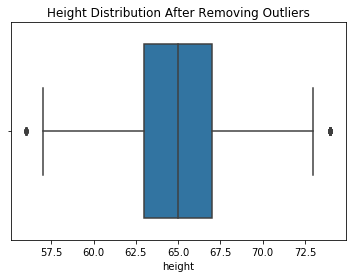

In [39]:
sns.boxplot(x=rtr.height).set_title('Height Distribution After Removing Outliers');

#### Column: item_id

I'm not sure how the item_id numbers are assigned. There are about 5700 unique items. It would be interesting to incorporate this column at some point but for my initial models I will drop this column.

In [40]:
rtr.item_id.nunique()

5706

In [41]:
rtr.item_id.value_counts()

126335     1484
123793     1313
174086     1265
145906     1101
127865     1053
132738     1052
137585      881
172027      828
136110      820
131533      740
131117      732
152836      649
166633      641
125465      602
124204      593
130259      578
136860      531
154002      501
123373      470
1226293     432
168592      410
168610      386
146684      384
125564      377
1076484     374
152662      367
138431      363
153475      363
128959      361
127495      359
           ... 
1196239       1
1276001       1
991459        1
2509134       1
2513391       1
1152022       1
791120        1
2847946       1
1898573       1
588440        1
2338852       1
2108705       1
1801547       1
908394        1
2409928       1
2880942       1
849722        1
2455807       1
522330        1
1506520       1
2913473       1
2953965       1
2665050       1
2437099       1
1209067       1
2895264       1
872676        1
261938        1
247349        1
1329015       1
Name: item_id, Length: 5

In [42]:
rtr.drop(columns='item_id', inplace=True)

In [43]:
rtr.head()

,age,fit,height,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow
0,28.0,1,68.0,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0
1,36.0,1,66.0,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1
3,34.0,1,65.0,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0
4,27.0,1,69.0,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0
5,45.0,1,68.0,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0


#### Column: rating

In [44]:
rtr.rating.value_counts()

10.0    90597
8.0     39239
6.0      8038
4.0      2118
2.0       736
Name: rating, dtype: int64

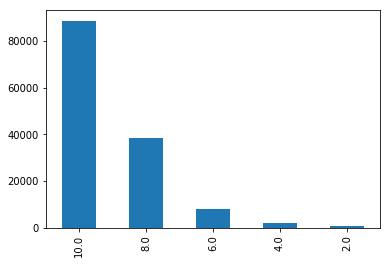

In [156]:
rtr.rating.value_counts().plot(kind='bar')

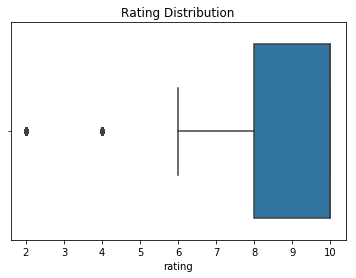

In [45]:
sns.boxplot(x=rtr.rating).set_title('Rating Distribution');

In [46]:
rtr['rating_binary'] = rtr.rating.map({10.0:1, 8:0, 6:0, 4:0, 2:0})
rtr.head()

,age,fit,height,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary
0,28.0,1,68.0,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0,1
1,36.0,1,66.0,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1,1
3,34.0,1,65.0,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0,0
4,27.0,1,69.0,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0,1
5,45.0,1,68.0,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0,0


In [47]:
rtr.rating_binary.value_counts()

1    90597
0    50131
Name: rating_binary, dtype: int64

#### Column: rented_for

This column may contain valuable information. I will use one hot encoding to transform this column into a more usable format. 

In [48]:
rtr.rented_for.value_counts()

wedding            41394
formal affair      29104
party              26146
everyday           12603
work               11633
other              10988
date                5737
vacation            3122
party: cocktail        1
Name: rented_for, dtype: int64

In [49]:
rtr.loc[rtr['rented_for'] == 'party: cocktail', 'rented_for'] = 'party'

In [50]:
rtr.rented_for.value_counts()

wedding          41394
formal affair    29104
party            26147
everyday         12603
work             11633
other            10988
date              5737
vacation          3122
Name: rented_for, dtype: int64

In [51]:
dummies = pd.get_dummies(rtr['rented_for'])

In [52]:
dict = {'wedding': 'event_wedding', 'formal affair': 'event_formal','everyday': 'event_everyday', 'work': 'event_work',
        'other': 'event_other', 'date': 'event_date', 'vacation': 'event_vacation', 'party': 'event_party'}

In [53]:
dummies.head()

,date,everyday,formal affair,other,party,vacation,wedding,work
0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0


In [54]:
dummies.columns = dummies.columns.map(dict)

In [55]:
dummies.head()

,event_date,event_everyday,event_formal,event_other,event_party,event_vacation,event_wedding,event_work
0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0


In [56]:
merged = pd.concat([rtr, dummies], axis=1)
merged.head()

,age,fit,height,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_other,event_party,event_vacation,event_wedding,event_work
0,28.0,1,68.0,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
1,36.0,1,66.0,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
3,34.0,1,65.0,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,27.0,1,69.0,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
5,45.0,1,68.0,8.0,date,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [57]:
rtr = merged.drop(['rented_for', 'event_other'], axis=1)
rtr.head()

,age,fit,height,rating,review_date,review_summary,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_party,event_vacation,event_wedding,event_work
0,28.0,1,68.0,10.0,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0,1,0,0,0,0,1,0,0
1,36.0,1,66.0,10.0,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,34.0,1,65.0,8.0,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,27.0,1,69.0,10.0,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0,1,0,0,0,0,0,1,0
5,45.0,1,68.0,8.0,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Column: review_date

This column contains the date that the customer left the review. It could be used to do a time series analysis on the orders to explore whether the rating is affected by seasonality or how the company has improved over time. For the sake of my machine learning problem, I will choose to drop this column.

In [58]:
rtr['review_date'] = pd.to_datetime(rtr['review_date'])

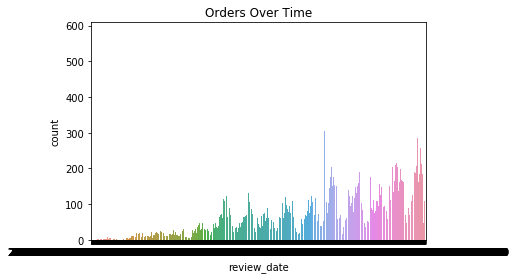

In [59]:
sns.countplot(x=rtr.review_date).set_title('Orders Over Time');

In [60]:
rtr.drop(columns='review_date', inplace=True)

#### Column: review_summary

This column contains short sentences summarizing the customer's review. To convert this column to a numeric value, I will use **natural language processing**. The range will be from -1 to 1.

In [61]:
sentiment = []
for review in rtr.review_summary:
    blob = TextBlob(review)
    sentiment.append(blob.sentiment.polarity)
rtr['review_summary_sentiment'] = sentiment

In [62]:
rtr.drop(columns='review_summary', inplace=True)
rtr.head()

,age,fit,height,rating,review_text,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_party,event_vacation,event_wedding,event_work,review_summary_sentiment
0,28.0,1,68.0,10.0,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.625000
1,36.0,1,66.0,10.0,I rented this dress for a photo shoot. The the...,12,273551,132lbs,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.000000
3,34.0,1,65.0,8.0,I rented this for my company's black tie award...,8,909926,135lbs,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.000000
4,27.0,1,69.0,10.0,I have always been petite in my upper body and...,12,151944,145lbs,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.976562
5,45.0,1,68.0,8.0,Didn't actually wear it. It fit perfectly. The...,8,734848,138lbs,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000


#### Column: review_text

This column contains the full text of the customer's review. To convert this column to a numeric value, I will use **natural language processing**. The range will be from -1 to 1.

In [63]:
sentiment = []
for review in rtr.review_text:
    blob = TextBlob(review)
    sentiment.append(blob.sentiment.polarity)
rtr['review_text_sentiment'] = sentiment

In [64]:
rtr.drop(columns='review_text', inplace=True)
rtr.head()

,age,fit,height,rating,size,user_id,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_party,event_vacation,event_wedding,event_work,review_summary_sentiment,review_text_sentiment
0,28.0,1,68.0,10.0,14,420272,137lbs,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.625000,0.181548
1,36.0,1,66.0,10.0,12,273551,132lbs,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.000000,0.360667
3,34.0,1,65.0,8.0,8,909926,135lbs,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.000000,0.213056
4,27.0,1,69.0,10.0,12,151944,145lbs,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.976562,-0.054028
5,45.0,1,68.0,8.0,8,734848,138lbs,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.308929


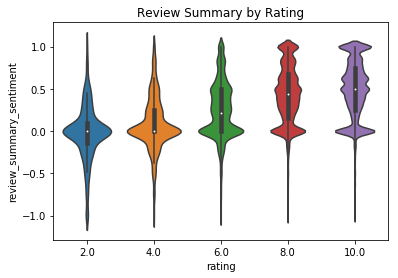

In [65]:
sns.violinplot(x=rtr['rating'], y=rtr['review_summary_sentiment']
              ).set_title('Review Summary by Rating');

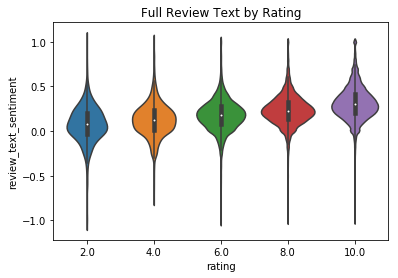

In [66]:
sns.violinplot(x=rtr['rating'], y=rtr['review_text_sentiment']
              ).set_title('Full Review Text by Rating');

**Observations**

The mean of the summary review is higher than the mean of the full review text. 

#### Column: size

In [67]:
rtr['size'].value_counts()

8     31871
4     23798
12    18411
16    12274
20    12046
1     11133
14     8696
24     5581
9      2065
13     1950
28     1924
17     1454
5      1402
21     1103
25      745
32      613
2       604
39      572
3       572
26      511
7       503
35      471
0       431
45      396
11      305
29      284
15      240
51      216
36      100
57       78
19       67
23       43
40       41
42       37
46       34
27       26
48       25
33       19
43       12
52       12
49       10
22        8
58        8
34        6
54        6
6         5
38        4
30        3
56        3
18        3
10        2
44        2
41        1
37        1
50        1
Name: size, dtype: int64

In [68]:
len(rtr)

140728

In [69]:
rtr = remove_outliers(rtr, 'size')

In [70]:
len(rtr)

139846

In [71]:
rtr['size'].value_counts()

8     31871
4     23798
12    18411
16    12274
20    12046
1     11133
14     8696
24     5581
9      2065
13     1950
28     1924
17     1454
5      1402
21     1103
25      745
32      613
2       604
3       572
39      572
26      511
7       503
35      471
0       431
11      305
29      284
15      240
36      100
19       67
23       43
27       26
33       19
22        8
34        6
6         5
38        4
18        3
30        3
10        2
37        1
Name: size, dtype: int64

#### Column: user_id

In [72]:
rtr.user_id.describe()

count    139846.000000
mean     498514.857708
std      289808.139398
min           9.000000
25%      249257.000000
50%      497484.500000
75%      750643.000000
max      999997.000000
Name: user_id, dtype: float64

In [73]:
rtr.drop(columns='user_id', inplace=True)

In [74]:
rtr.head()

,age,fit,height,rating,size,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_party,event_vacation,event_wedding,event_work,review_summary_sentiment,review_text_sentiment
0,28.0,1,68.0,10.0,14,137lbs,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.625000,0.181548
1,36.0,1,66.0,10.0,12,132lbs,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.000000,0.360667
3,34.0,1,65.0,8.0,8,135lbs,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.000000,0.213056
4,27.0,1,69.0,10.0,12,145lbs,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.976562,-0.054028
5,45.0,1,68.0,8.0,8,138lbs,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.308929


#### Column: weight

In [75]:
rtr.weight = rtr.weight.apply(lambda x: float(x.strip('lbs')))

In [76]:
rtr.head()

,age,fit,height,rating,size,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_party,event_vacation,event_wedding,event_work,review_summary_sentiment,review_text_sentiment
0,28.0,1,68.0,10.0,14,137.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.625000,0.181548
1,36.0,1,66.0,10.0,12,132.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.000000,0.360667
3,34.0,1,65.0,8.0,8,135.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.000000,0.213056
4,27.0,1,69.0,10.0,12,145.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.976562,-0.054028
5,45.0,1,68.0,8.0,8,138.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.308929


In [77]:
len(rtr)

139846

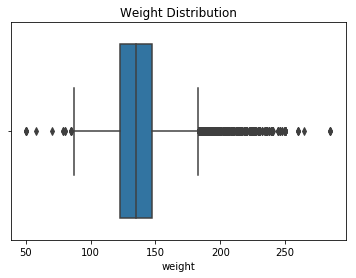

In [78]:
sns.boxplot(x=rtr.weight).set_title('Weight Distribution');

In [79]:
rtr = remove_outliers(rtr, 'weight')
len(rtr)

137689

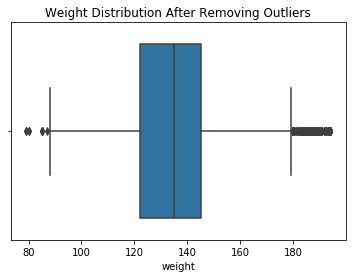

In [80]:
sns.boxplot(x=rtr.weight).set_title('Weight Distribution After Removing Outliers');

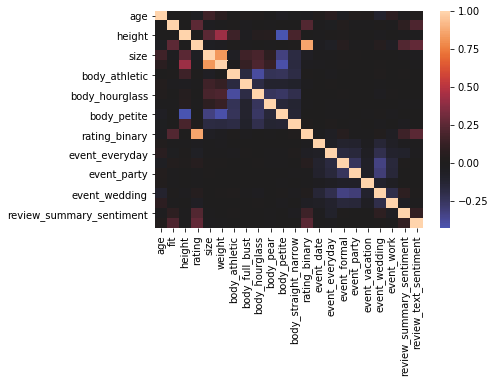

In [81]:
sns.heatmap(rtr.corr(), center=0);

## Modeling

* Binary classification based on rating of 10 or less than 10

* Metrics

Precision = True Positive / Actual Results (false positives)

Recall = True Positive / Predicted Results (false negatives)

Accuracy = (True Positive + True Negative) / Total

F1 Score = harmonic mean of precision and recall

In [82]:
rtr.head()

,age,fit,height,rating,size,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_party,event_vacation,event_wedding,event_work,review_summary_sentiment,review_text_sentiment
0,28.0,1,68.0,10.0,14,137.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.625000,0.181548
1,36.0,1,66.0,10.0,12,132.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.000000,0.360667
3,34.0,1,65.0,8.0,8,135.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.000000,0.213056
4,27.0,1,69.0,10.0,12,145.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.976562,-0.054028
5,45.0,1,68.0,8.0,8,138.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.308929


In [83]:
rtr.columns

Index(['age', 'fit', 'height', 'rating', 'size', 'weight', 'body_athletic',
       'body_full_bust', 'body_hourglass', 'body_pear', 'body_petite',
       'body_straight_narrow', 'rating_binary', 'event_date', 'event_everyday',
       'event_formal', 'event_party', 'event_vacation', 'event_wedding',
       'event_work', 'review_summary_sentiment', 'review_text_sentiment'],
      dtype='object')

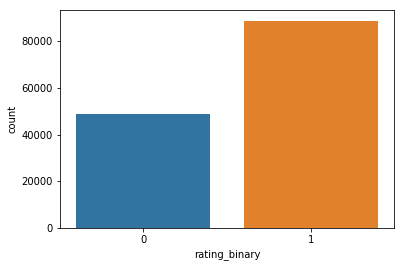

In [84]:
sns.countplot(rtr['rating_binary']);

In [85]:
rtr.columns

Index(['age', 'fit', 'height', 'rating', 'size', 'weight', 'body_athletic',
       'body_full_bust', 'body_hourglass', 'body_pear', 'body_petite',
       'body_straight_narrow', 'rating_binary', 'event_date', 'event_everyday',
       'event_formal', 'event_party', 'event_vacation', 'event_wedding',
       'event_work', 'review_summary_sentiment', 'review_text_sentiment'],
      dtype='object')

In [86]:
# First I will look forward to see if I can predict fit based on a customer's information.
X = rtr.drop(['fit', 'rating', 'rating_binary', 'review_summary_sentiment', 'review_text_sentiment'], axis=1)
y = rtr['rating_binary']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [88]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Baseline Model

In [89]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=seed) 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [90]:
# Cross validation
tree_cv_score = cross_val_score(tree_clf, X_train, y_train, cv=3)
mean_tree_cv_score = np.mean(tree_cv_score)

print(f"Mean Cross Validation Score: {mean_tree_cv_score :.2%}")

Mean Cross Validation Score: 64.39%


In [91]:
X.columns

Index(['age', 'height', 'size', 'weight', 'body_athletic', 'body_full_bust',
       'body_hourglass', 'body_pear', 'body_petite', 'body_straight_narrow',
       'event_date', 'event_everyday', 'event_formal', 'event_party',
       'event_vacation', 'event_wedding', 'event_work'],
      dtype='object')

In [92]:
def plot_feature_importances(model, title='Feature Importance for Model'):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title(title)


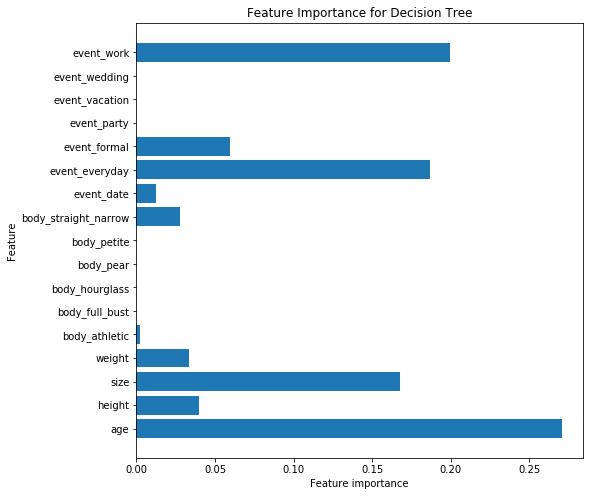

In [93]:
plot_feature_importances(tree_clf, "Feature Importance for Decision Tree")

In [94]:
# Test set predictions
pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[   31 12168]
 [   47 22177]]
              precision    recall  f1-score   support

           0       0.40      0.00      0.01     12199
           1       0.65      1.00      0.78     22224

    accuracy                           0.65     34423
   macro avg       0.52      0.50      0.39     34423
weighted avg       0.56      0.65      0.51     34423



In [95]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 64.52%


In [96]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20, random_state=seed)

In [97]:
# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
   

In [98]:
# Training accuracy score
bagged_tree.score(X_train, y_train)

0.6447717544980923

In [99]:
# Test accuracy score
bagged_tree.score(X_test, y_test)

0.6457891526014583

In [100]:
#For reproducibility 
seed = 42

In [101]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, min_samples_split=50, n_jobs=-1, random_state=seed)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [102]:
# Training accuracy score
forest.score(X_train, y_train)

0.6779869463327717

In [103]:
# Test accuracy score
forest.score(X_test, y_test)

0.643813729192691

In [104]:
predictions = forest.predict(X_test)
print(f"Train Accuracy: {accuracy_score(y_train, forest.predict(X_train))}")
print(f"Test Accuracy: {accuracy_score(y_test, predictions)}")

Train Accuracy: 0.6779869463327717
Test Accuracy: 0.643813729192691


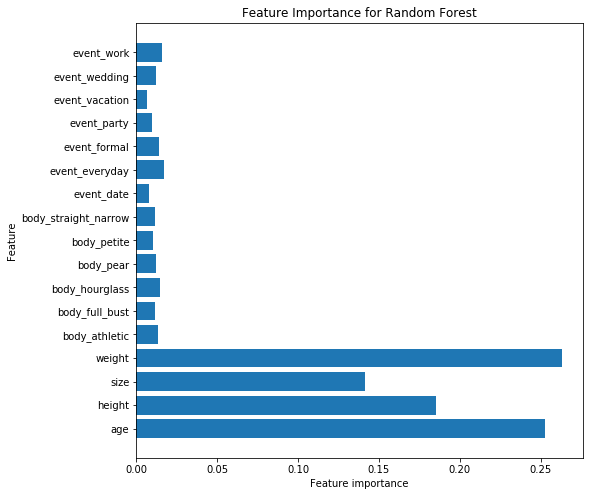

In [105]:
plot_feature_importances(forest, "Feature Importance for Random Forest")

None of these models are very good. I think it is because our target data is imbalanced. I will try balancing the data using the SMOTE method. 

In [106]:
sm = SMOTE(random_state=seed)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [107]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 66524
Before OverSampling, counts of label '0': 36742 

After OverSampling, the shape of train_X: (133048, 17)
After OverSampling, the shape of train_y: (133048,) 

After OverSampling, counts of label '1': 66524
After OverSampling, counts of label '0': 66524


In [108]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=seed) 
tree_clf.fit(X_train_res, y_train_res.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [109]:
tree_cv_score = cross_val_score(tree_clf, X_train_res, y_train_res.ravel(), cv=3)
mean_tree_cv_score = np.mean(tree_cv_score)

print(f"Mean Cross Validation Score: {mean_tree_cv_score :.2%}")

Mean Cross Validation Score: 54.22%


In [110]:
from sklearn.linear_model import LogisticRegression 

In [111]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.42      0.00      0.01     12199
           1       0.65      1.00      0.78     22224

    accuracy                           0.65     34423
   macro avg       0.53      0.50      0.40     34423
weighted avg       0.57      0.65      0.51     34423

[[   47 12152]
 [   64 22160]]


In [112]:
lr1 = LogisticRegression() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.48      0.44     12199
           1       0.68      0.61      0.64     22224

    accuracy                           0.56     34423
   macro avg       0.54      0.54      0.54     34423
weighted avg       0.58      0.56      0.57     34423

[[ 5807  6392]
 [ 8690 13534]]


In [113]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_res, y_train_res)
pred_rfc = rfc.predict(X_test)

In [114]:
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.39      0.34      0.37     12199
           1       0.66      0.71      0.69     22224

    accuracy                           0.58     34423
   macro avg       0.53      0.53      0.53     34423
weighted avg       0.57      0.58      0.57     34423

[[ 4180  8019]
 [ 6417 15807]]


In [115]:
mean_rf_cv_score = np.mean(cross_val_score(rfc, X_train_res, y_train_res, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 66.63%


In [116]:
rf_param_grid = {
    'n_estimators': [20, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [117]:
rf_grid_search = GridSearchCV(rfc, rf_param_grid, cv=3, n_jobs=-1, verbose=1, )
rf_grid_search.fit(X_train_res, y_train_res)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 14.4min finished


Training Accuracy: 66.68%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}


In [118]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, min_samples_split=5, 
                             random_state=seed, n_jobs=-1)
rfc.fit(X_train_res, y_train_res)
pred_rfc = rfc.predict(X_test)

In [119]:
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.41      0.32      0.36     12199
           1       0.67      0.74      0.70     22224

    accuracy                           0.59     34423
   macro avg       0.54      0.53      0.53     34423
weighted avg       0.57      0.59      0.58     34423

[[ 3907  8292]
 [ 5723 16501]]


In [120]:
rf_grid_search.score(X_test, y_test)

0.5952415536124103

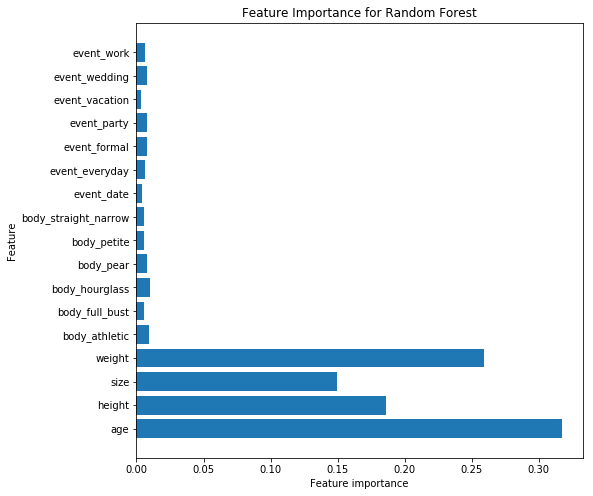

In [121]:
plot_feature_importances(rfc, "Feature Importance for Random Forest")

In [164]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=seed)

# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=seed)

In [165]:
adaboost_clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

In [166]:
gbt_clf.fit(X_train_res, y_train_res)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [181]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))


In [182]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train_res)
adaboost_test_preds = adaboost_clf.predict(X_test)


In [183]:
print("AdaBoost Training Metrics")
display_acc_and_f1_score(y_train_res, adaboost_train_preds, model_name='AdaBoost')
print("")

print("AdaBoost Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")

print("AdaBoost Model")
print(classification_report(y_test, adaboost_test_preds))
print(confusion_matrix(y_test, adaboost_test_preds))

AdaBoost Training Metrics
Model: AdaBoost
Accuracy: 0.5808730683663039
F1-Score: 0.5995173869953031

AdaBoost Testing Metrics
Model: AdaBoost
Accuracy: 0.5699968044621329
F1-Score: 0.6545946702758203

AdaBoost Model
              precision    recall  f1-score   support

           0       0.41      0.46      0.43     12199
           1       0.68      0.63      0.65     22224

    accuracy                           0.57     34423
   macro avg       0.54      0.54      0.54     34423
weighted avg       0.58      0.57      0.58     34423

[[ 5595  6604]
 [ 8198 14026]]


In [184]:
# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(X_train_res)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [185]:
print("Gradient Boost Training Metrics")
display_acc_and_f1_score(y_train_res, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Gradient Boost Testing Metrics")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')
print("")
print("Gradient Boost Model")
print(classification_report(y_test, gbt_clf_test_preds))
print(confusion_matrix(y_test, gbt_clf_test_preds))


Gradient Boost Training Metrics
Model: Gradient Boosted Trees
Accuracy: 0.6645872166436173
F1-Score: 0.7073282703078476

Gradient Boost Testing Metrics
Model: Gradient Boosted Trees
Accuracy: 0.6116549981117276
F1-Score: 0.728623629719854

Gradient Boost Model
              precision    recall  f1-score   support

           0       0.42      0.25      0.32     12199
           1       0.66      0.81      0.73     22224

    accuracy                           0.61     34423
   macro avg       0.54      0.53      0.52     34423
weighted avg       0.58      0.61      0.58     34423

[[ 3109  9090]
 [ 4278 17946]]


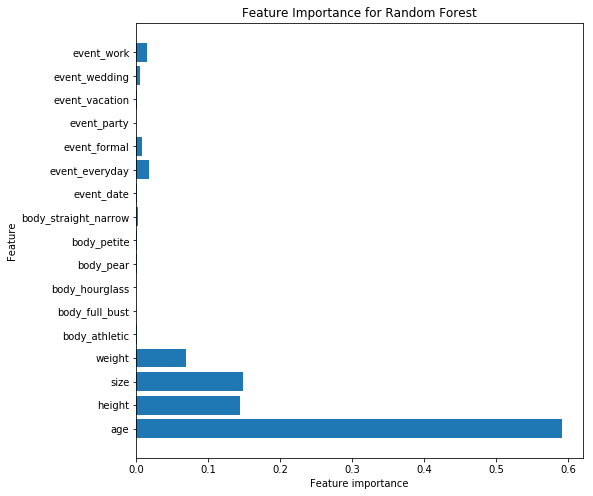

In [186]:
plot_feature_importances(gbt_clf, "Feature Importance for Random Forest")

In [123]:
rtr.head()

,age,fit,height,rating,size,weight,body_athletic,body_full_bust,body_hourglass,body_pear,body_petite,body_straight_narrow,rating_binary,event_date,event_everyday,event_formal,event_party,event_vacation,event_wedding,event_work,review_summary_sentiment,review_text_sentiment
0,28.0,1,68.0,10.0,14,137.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.625000,0.181548
1,36.0,1,66.0,10.0,12,132.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.000000,0.360667
3,34.0,1,65.0,8.0,8,135.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1.000000,0.213056
4,27.0,1,69.0,10.0,12,145.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.976562,-0.054028
5,45.0,1,68.0,8.0,8,138.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000000,0.308929


In [124]:
rtr.age.describe()

count    137689.000000
mean         33.130766
std           6.513794
min          14.000000
25%          29.000000
50%          32.000000
75%          37.000000
max          52.000000
Name: age, dtype: float64

In [129]:
rtr['age_groups'] = pd.cut(rtr['age'], [0, 20, 30, 40, 52], labels=['14-20', '21-30', '31-40', '40-52'])

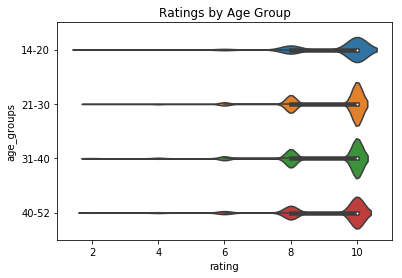

In [131]:
sns.violinplot(x=rtr['rating'], y=rtr['age_groups']
              ).set_title('Ratings by Age Group');

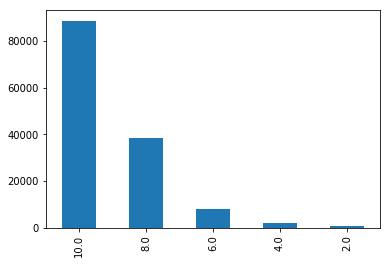

In [159]:
rtr.rating.value_counts().plot(kind='bar')

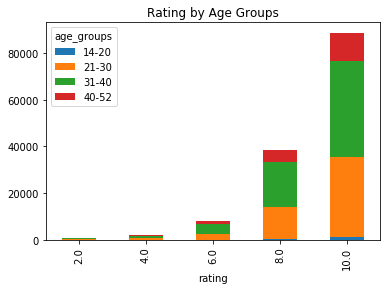

In [162]:
rtr.groupby(['rating', 'age_groups']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Rating by Age Groups')
plt.show()

## Future Work


### Recommendation System

* Based on information about a customer, recommend items likely to fit.

### Hypothesis Testing

* Is there a statistically significant correlation between fit and rating?